In [192]:
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import altair as alt
# need to 'pip install vega' before using renderer
alt.renderers.enable("notebook")
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing,metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve,StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
%matplotlib inline
#fix random seed
np.random.seed(1)

In [193]:
!jupyter nbextension enable vega --py --sys-prefix

Enabling notebook extension jupyter-vega/index...
      - Validating: OK


In [194]:
df = pd.read_csv('training.csv')
print(df.isnull().sum())
df.head(5)

article_number    0
article_words     0
topic             0
dtype: int64


,article_number,article_words,topic
0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS
1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS
2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS
3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS
4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT


In [195]:
#new_df = df[df.topic!='IRRELEVANT'] # We remove rows that are "IRRELEVANT"
new_df = df
data_x = new_df.article_words
data_y = new_df.topic

train_x,dev_x,train_y,dev_y = train_test_split(data_x,data_y,test_size = 0.1,shuffle=False)
le = preprocessing.LabelEncoder()
en_train_y = le.fit_transform(train_y)
en_dev_y = le.fit_transform(dev_y)
topics=list(set(df['topic']))
print(topics)

['BIOGRAPHIES PERSONALITIES PEOPLE', 'HEALTH', 'MONEY MARKETS', 'SPORTS', 'IRRELEVANT', 'SCIENCE AND TECHNOLOGY', 'DEFENCE', 'SHARE LISTINGS', 'ARTS CULTURE ENTERTAINMENT', 'DOMESTIC MARKETS', 'FOREX MARKETS']


In [196]:
print(le.inverse_transform(en_train_y))

['FOREX MARKETS' 'MONEY MARKETS' 'SPORTS' ... 'IRRELEVANT' 'FOREX MARKETS'
 'IRRELEVANT']


In [197]:
print(train_y)

0       FOREX MARKETS
1       MONEY MARKETS
2              SPORTS
3       FOREX MARKETS
4          IRRELEVANT
            ...      
8545           SPORTS
8546       IRRELEVANT
8547       IRRELEVANT
8548    FOREX MARKETS
8549       IRRELEVANT
Name: topic, Length: 8550, dtype: object


### Transform Training Text to TF-IDF 

In [198]:
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_x)
dev_vectors = vectorizer.transform(dev_x)
print(train_vectors.shape,dev_vectors.shape)
print(train_vectors.nnz/float(train_vectors.shape[0]))

(8550, 34039) (950, 34039)
80.04350877192982


From the output above, it could be seen that the extracted TF-IDF vectors from training set are sparse, as there are only 81 non-zero features over 23012 features.

### Using SMOTE to Solve Data Imbalance

 First, by plotting each topic's frequency, it could be seen that the distribution of topics is imbalanced.

In [199]:
train_y.to_frame()

,topic
0,FOREX MARKETS
1,MONEY MARKETS
2,SPORTS
3,FOREX MARKETS
4,IRRELEVANT
...,...
8545,SPORTS
8546,IRRELEVANT
8547,IRRELEVANT
8548,FOREX MARKETS


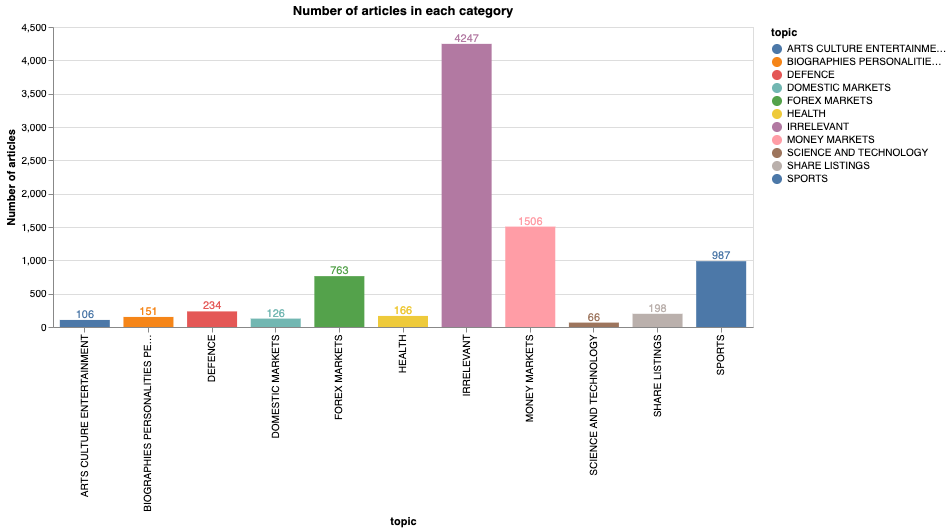

In [200]:
alt.data_transformers.disable_max_rows()
bars = alt.Chart(train_y.to_frame()).mark_bar(size=50).encode(
    x=alt.X("topic"),
    y=alt.Y("count():Q", axis=alt.Axis(title='Number of articles')),
    tooltip=[alt.Tooltip('count()', title='Number of articles'), 'topic'],
    color='topic'

)

text = bars.mark_text(
    align='center',
    baseline='bottom',
).encode(
    text='count()'
)

(bars + text).properties(
    height=300, 
    width=700,
    title = "Number of articles in each category",
)



Considering in the data set, the topic 'MONEY MARKET' occupies the majority, which might, indirectly, lead to biased prediction to itself, we need to adjust each topic's proportion in the training data set. In this project, SMOTE (Synthetic Minority Over-sampling TEchnique) is used to solve the imbalance problem.

In [201]:
smote = SMOTE(random_state=1)
smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)

### Optimal Hyper-parameter

<b>Warning: The following block runs for a long time, don't run it if not necessary</b>

In [202]:
# # alpha = [0.001*n for n in range(1,1001)]
# alpha = [0.01*n for n in range(1,101)]

# fit_prior = [True,False]
# # After using SMOTE to improve the imbalance, we can assume the distribution is uniform distribution
# prior = [1/len(topics) for i in range(len(topics))]
# class_prior = [None,prior]
# kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
# param_grid = dict(alpha=alpha,fit_prior=fit_prior,class_prior=class_prior)
# grid_search = GridSearchCV(MultinomialNB(),param_grid,scoring='neg_log_loss',n_jobs=-1,cv=kfold)
# grid_result = grid_search.fit(smo_x,smo_y)
# print("The best parameters are {0}, with score {1:4}".format(grid_result.best_params_,grid_result.best_score_))

In [203]:
def get_scores(en_dev_y,pred_y,model_name,topic=None):
    if(topic==None):
        print("F1 score for ",model_name," model is ",f1_score(en_dev_y,pred_y,average='macro'))
        print("Accuracy score for ",model_name," model is ",accuracy_score(en_dev_y,pred_y))
        print("Recall score for ",model_name," model is ",recall_score(en_dev_y,pred_y,average='macro'))
    else:
        print("F1 score of ",topic," for ",model_name," model is ",f1_score(en_dev_y,pred_y,average='macro'))
        print("Accuracy score of ",topic," for ",model_name," model is ",accuracy_score(en_dev_y,pred_y))
        print("Recall score of ",topic," for ",model_name," model is ",recall_score(en_dev_y,pred_y,average='macro'))

### MultinomialNB Method

In [204]:
# Fit data
clf = MultinomialNB(alpha=0.003)
clf.fit(smo_x,smo_y)
pred_y = clf.predict(dev_vectors)
get_scores(en_dev_y,pred_y,'MultinomialNB')

F1 score for  MultinomialNB  model is  0.6243282286371143
Accuracy score for  MultinomialNB  model is  0.751578947368421
Recall score for  MultinomialNB  model is  0.6454504196521257


In [154]:
proba_y = clf.predict_proba(dev_vectors)
print(min([max(lst) for lst in proba_y]))

0.32859926335161416


In [162]:
irr_data = df[df.topic=='IRRELEVANT']
irr_x = irr_data.article_words
irr_y = irr_data.topic
en_irr_y = le.fit_transform(irr_y)
irr_vectors = vectorizer.transform(irr_x)
irr_proba_y = clf.predict_proba(irr_vectors)
print(max([max(lst) for lst in irr_proba_y]))

1.0


[[2.57018943e-03 1.06126299e-03 1.34539591e-04 3.54144840e-02
  2.40369822e-03 9.24599041e-01 4.85056730e-04 3.32146977e-02
  1.04970940e-04 1.20592553e-05]]


## Result for Test Set

In [114]:
df = pd.read_csv('test.csv')
print(df.isnull().sum())
df.head(5)

article_number    0
article_words     0
topic             0
dtype: int64


,article_number,article_words,topic
0,9501,"world,complet,pharmaceut,tianjin,tianjin,chin,...",IRRELEVANT
1,9502,"copy,sunday,weekend,ec,friday,eu,includ,limit,...",IRRELEVANT
2,9503,"heavy,heavy,gabriel,morn,morn,equit,cent,cent,...",FOREX MARKETS
3,9504,"research,jess,hit,anticip,comput,comput,comput...",IRRELEVANT
4,9505,"provid,provid,luxembourg,court,court,case,opin...",IRRELEVANT


#### Scores for Topics

In [108]:
def scores_for_topics(df,topics,model):
    for topic in topics:
        topic_scores(df,topic,model)

def topic_scores(df,topic,model):
    new_df = df[df.topic==topic]
    

In [109]:
scores_for_topics(df,topics,clf)

ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead